# Applied Data Science Capstone of IBM Course 

## Introduction

The goal of this project it's to help people explore facilities around neighborhods to make smart and efficient desicion on selecting a good place to live. It can be applied to many different situations such as: exploring the nightlife of a city, buy a house depending on the near facilities that suround the property, look for hotels near good restaurants when you travel, etc. 

For this project we are going to work with the following scenario:
As an entrepeneur, one of my dreams is to open a craft brewery and since we are going to work with Toronto' data, I'm going to simulate where to open this bussines. There are several more factors when it comes to opening a bussines, but this project will help to gather data and get a starting point to locate a good spot.

### Importing libraries

In [6]:
import pandas as pd
import numpy as np
import json 
import geocoder
import requests  
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup 
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim 
import wikipedia as wp
print("Libraries imported succesfuly")

Libraries imported succesfuly


### Data Cleaning

In [24]:
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=926287641"
dfs = pd.read_html(url)
df = dfs[0]

df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
df.loc[df["Neighbourhood"] == 'Not assigned', "Neighbourhood"] = df["Borough"]

df = df.groupby(['Borough','Postcode'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

coor = pd.read_csv("Geospatial_Coordinates.csv")
coor = coor.rename(columns={'Postal Code': 'Postcode'})

toronto = pd.merge(df, coor, how='left', left_on = 'Postcode', right_on = 'Postcode')
toronto = toronto.rename(columns={'Neighbourhood':'Neighborhood'})
toronto.head()

,Borough,Postcode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In order to get data about this particular location (Toronto), we are using Foursquare API. This plataform it's a location data provider where we can gather information of all manner of venues and events within our area of interest. The API returns a JSON file that we can convert into a dataframe.

In [27]:
CLIENT_ID = '11X0WO5ZUSRAIV13FG3WZXTAOFGKLONM2FAZYYQZSET1VGEU'
CLIENT_SECRET = 'A3OKYXCYVHXGPA5X0RKXEFHID5KCNEBKUNMKAQR4B4ZFP3B5'
ACCESS_TOKEN = 'JWPPNQI0R4ZTHM3YPYUAQEEACNHNJ31BEITQP012TUHPFMUK'
VERSION = '20180604'

In [25]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


We want to get the 100 most popular venues within a radius of 1000 meters for given coordinates.

In [28]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

<ipython-input-28-bc18f4b49c39>:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,LUSH,Cosmetics Shop,43.653557,-79.380400
3,Poke Guys,Poke Place,43.654895,-79.385052
4,Textile Museum of Canada,Art Museum,43.654396,-79.386500


In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
         #url to fetch data from foursquare api
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # get all the data
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
LIMIT=100
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Business Reply Mail Processing Centre 969 Eastern
Woodbine Gardens, Parkview Hill
Woodbine Heights
Leaside
Thorncl

In [32]:
toronto_venues.head(5)

,Neighborhood,Latitude,Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.72802,-79.38879,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.72802,-79.38879,Granite Club,43.733043,-79.381986,Gym / Fitness Center
2,Lawrence Park,43.72802,-79.38879,Tim Hortons,43.727324,-79.379563,Coffee Shop
3,Lawrence Park,43.72802,-79.38879,Glendon Bookstore,43.727024,-79.378976,Bookstore
4,Lawrence Park,43.72802,-79.38879,Glendon Forest,43.727226,-79.378413,Trail


## Exploratory data analysis

We can start by checking how many venues were returned for each neighborhood, get the unique categories for the returned venues, count each category in each neighborhood. This will give us a general idea of each neighborhood. 

In [33]:
toronto_venues.groupby('Neighborhood').count().head()

,Latitude,Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,45,45,45,45,45,45
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",33,33,33,33,33,33
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",17,17,17,17,17,17
"Alderwood, Long Branch",24,24,24,24,24,24


In [34]:
len(toronto_venues['Venue Category'].unique())

325

In [36]:
toronto_venues['Venue Category'].unique()[0:20]

array(['Park', 'Gym / Fitness Center', 'Coffee Shop', 'Bookstore',
       'Trail', 'College Quad', 'Café', 'College Gym',
       'Food & Drink Shop', 'Supermarket', 'Bakery', 'Italian Restaurant',
       'Dessert Shop', 'Yoga Studio', 'Breakfast Spot', 'Deli / Bodega',
       'Vegetarian / Vegan Restaurant', 'Ramen Restaurant', 'Wine Bar',
       'Vietnamese Restaurant'], dtype=object)

In [37]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(4903, 325)


,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(102, 325)


,Neighborhood,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,...,0.010000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.01
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,...,0.000000,0.0,0.000000,0.022222,0.0,0.0,0.0,0.0,0.0,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.030303,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.058824,0.000000,0.0,0.0,0.0,0.0,0.0,0.00
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00


In [39]:
venue_counts = toronto_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",0,0,0,0,0,0,0,0,2,0,...,1,0,0,0,0,0,0,0,0,1
Agincourt,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
venue_counts_described = venue_counts.describe().transpose()

venue_top20 = venue_counts_described.sort_values('max', ascending=False)[0:20]
venue_top20

,count,mean,std,min,25%,50%,75%,max
Coffee Shop,102.0,3.715686,3.404649,0.0,1.0,2.5,5.0,15.0
Korean Restaurant,102.0,0.274510,1.470212,0.0,0.0,0.0,0.0,13.0
Greek Restaurant,102.0,0.343137,1.396566,0.0,0.0,0.0,0.0,12.0
Café,102.0,2.078431,2.809765,0.0,0.0,1.0,3.0,11.0
Italian Restaurant,102.0,1.098039,1.512390,0.0,0.0,1.0,2.0,9.0
Indian Restaurant,102.0,0.460784,0.971592,0.0,0.0,0.0,1.0,7.0
Chinese Restaurant,102.0,0.480392,1.096623,0.0,0.0,0.0,1.0,7.0
Bubble Tea Shop,102.0,0.215686,0.712372,0.0,0.0,0.0,0.0,6.0
Ramen Restaurant,102.0,0.245098,0.788987,0.0,0.0,0.0,0.0,6.0
Bar,102.0,0.500000,1.272325,0.0,0.0,0.0,0.0,6.0


There are 325 unique categories in which Breweries are the 15th one 

In [103]:
Toronto_Venues_Top20 = toronto_venues['Venue Category'].value_counts()[0:21].to_frame(name='frequency')
Toronto_Venues_Top20 =Toronto_Venues_Top20.reset_index()
#Toronto_Venues_Top20

Toronto_Venues_Top20.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Toronto_Venues_Top20

,Venue_Category,Frequency
0,Coffee Shop,379
1,Café,212
2,Park,160
3,Pizza Place,151
4,Restaurant,145
5,Italian Restaurant,112
6,Bakery,100
7,Grocery Store,98
8,Japanese Restaurant,89
9,Sandwich Place,89


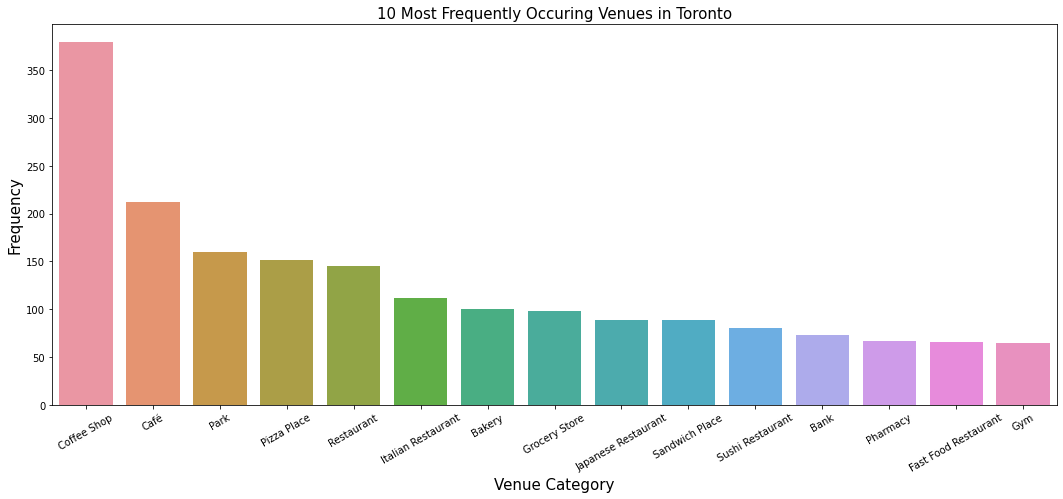

In [43]:
import seaborn as sns
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Toronto_Venues_Top20)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in Toronto', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.show()

Lets get a visual look of the neighborhoods at Toronto and it's relationship with breweries.

In [46]:
import folium

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

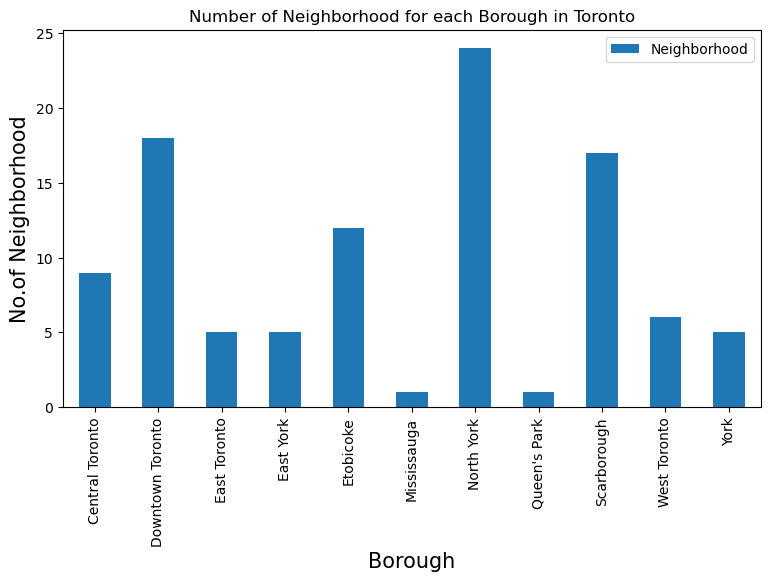

In [107]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in Toronto')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
toronto.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

We can see that North York has the highest number of neighborhoods. Now we want to know hoy many breweries are in each neighborhood.

In [76]:
toronto_part=toronto_grouped[['Neighborhood', 'Brewery']]
toronto_part

,Neighborhood,Brewery
0,"Adelaide, King, Richmond",0.000000
1,Agincourt,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000
4,"Alderwood, Long Branch",0.000000
...,...,...
97,Willowdale West,0.000000
98,Woburn,0.000000
99,"Woodbine Gardens, Parkview Hill",0.105263
100,Woodbine Heights,0.000000


In [77]:
toronto_merged = pd.merge(toronto, toronto_part, on='Neighborhood')
toronto_merged.max()

Borough                    York
Postcode                    M9W
Neighborhood    York Mills West
Latitude                43.8153
Longitude              -79.1605
Brewery                0.105263
dtype: object

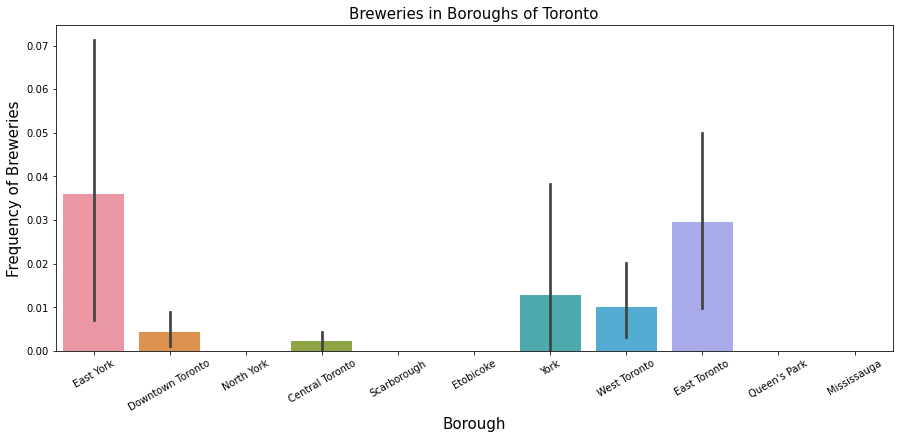

In [108]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,6))
s=sns.barplot(y="Brewery", x="Borough", data=toronto_merged);
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Breweries in Boroughs of Toronto', fontsize=15)
plt.xlabel("Borough", fontsize=15)
plt.ylabel ("Frequency of Breweries", fontsize=15)
plt.show()

On the contrary than the last plot, we can recall that North York has the most number of neighborhoods, however as we may see in this plot, there are no breweries at this location, such as Etobicoke, Mississauga, Queen's Park and Scarborough, this may indicate that these neighborhoods are mos likely residential.

On the other hand, East Toronto and East York have the most number of breweries by far than the rest.

## Predictive Modeling

Since we are going to use the K-means clustering algorithm, the first step is to identify the K value using the elbow method to get the optimal number of K. This method calculates the sum of squared distances of samples to their closest cluster center for different values of K. The value of K after which there is no siginificant decrease in sum of squared distances is choosen.

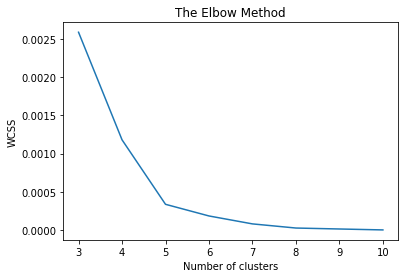

In [80]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_clustering = toronto_part.drop('Neighborhood', 1)

wcss = []

for i in range(3, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter= 50)
    kmeans.fit(toronto_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(3, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

It seems that K=5 is the best value for our model.

In [106]:
kclusters = 5

toronto_clustering = toronto_part.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1,
       2, 3, 4, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [82]:
toronto_merged = toronto_part.copy()
toronto_merged["Cluster Labels"] = kmeans.labels_
toronto_merged.head()

,Neighborhood,Brewery,Cluster Labels
0,"Adelaide, King, Richmond",0.0,1
1,Agincourt,0.0,1
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,1
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,1
4,"Alderwood, Long Branch",0.0,1


In [83]:
toronto_merged = toronto_merged.join(toronto.set_index("Neighborhood"), on="Neighborhood")
print(toronto_merged.shape)
toronto_merged.head()

(102, 7)


,Neighborhood,Brewery,Cluster Labels,Borough,Postcode,Latitude,Longitude
0,"Adelaide, King, Richmond",0.0,1,Downtown Toronto,M5H,43.650571,-79.384568
1,Agincourt,0.0,1,Scarborough,M1S,43.794200,-79.262029
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,1,Scarborough,M1V,43.815252,-79.284577
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,1,Etobicoke,M9V,43.739416,-79.588437
4,"Alderwood, Long Branch",0.0,1,Etobicoke,M8W,43.602414,-79.543484


In [84]:
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged

,Neighborhood,Brewery,Cluster Labels,Borough,Postcode,Latitude,Longitude
99,"Woodbine Gardens, Parkview Hill",0.105263,0,East York,M4B,43.706397,-79.309937
0,"Adelaide, King, Richmond",0.000000,1,Downtown Toronto,M5H,43.650571,-79.384568
69,"Newtonbrook, Willowdale",0.000000,1,North York,M2M,43.789053,-79.408493
68,"Moore Park, Summerhill East",0.000000,1,Central Toronto,M4T,43.689574,-79.383160
67,"Maryvale, Wexford",0.000000,1,Scarborough,M1R,43.750072,-79.295849
...,...,...,...,...,...,...,...
49,"Harbord, University of Toronto",0.010000,3,Downtown Toronto,M5S,43.662696,-79.400049
73,"Parkdale, Roncesvalles",0.010000,3,West Toronto,M6R,43.648960,-79.456325
12,Business Reply Mail Processing Centre 969 Eastern,0.062500,4,East Toronto,M7Y,43.662744,-79.321558
90,"The Junction North, Runnymede",0.063830,4,York,M6N,43.673185,-79.487262


In [102]:
import folium

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [92]:
cluster0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

In [93]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

In [94]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

In [95]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

In [96]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

In [98]:
print("Cluster 0 has {} results.".format(len(cluster0.index)))
print("Cluster 1 has {} results.".format(len(cluster1.index)))
print("Cluster 2 has {} results.".format(len(cluster2.index)))
print("Cluster 3 has {} results.".format(len(cluster3.index)))
print("Cluster 4 has {} results.".format(len(cluster4.index)))

Cluster 0 has 1 results.
Cluster 1 has 83 results.
Cluster 2 has 5 results.
Cluster 3 has 10 results.
Cluster 4 has 3 results.


## Results

Based on the visualizations and data sets generated we can conclude that:

* North York Etobicoke, Mississauga, Queen's Park and Scarborough have no breweries at this neighborhoods, which may indicate that these neighborhoods are most likely residential and may be not the optimal place to open a business.
* On the other hand neighborhoods like East Toronto and East York have the most number of breweries which may be strong competitors for our new business. It would be better to place our bussines at York or West Toronto that have a more humble number of breweries, or even at Central Toronto and Downtown Toronto that have the least number of breweries.
* Clustering gives us similar results, suggesting that opening brewery will be a good idea at 2 or 4.